In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas.tseries.offsets import DateOffset
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM 
from keras.layers import Dropout
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("AirQualityUCI.csv")

df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10-03-2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10-03-2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10-03-2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10-03-2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10-03-2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [3]:
df = df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1)
null_data = df[df.isnull().any(axis=1)]

In [4]:
df = df.dropna()

In [5]:
df = df.replace(-200, np.nan)

In [6]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

In [7]:
h = df['Time'].tolist()
l=[]
for i in range(len(h)):
    l.append(h[i].split(":")[0])
df['hour']=l

In [8]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [9]:
cols=["year","month","day","hour"]
df['date'] = df[cols].apply(lambda x: '/'.join(x.values.astype(str)), axis="columns")
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day,date
0,2004-03-10,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18,2004,3,10,2004/3/10/18
1,2004-03-10,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19,2004,3,10,2004/3/10/19
2,2004-03-10,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20,2004,3,10,2004/3/10/20
3,2004-03-10,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21,2004,3,10,2004/3/10/21
4,2004-03-10,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22,2004,3,10,2004/3/10/22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,10,2005,4,4,2005/4/4/10
9353,2005-04-04,11:00:00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,11,2005,4,4,2005/4/4/11
9354,2005-04-04,12:00:00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,12,2005,4,4,2005/4/4/12
9355,2005-04-04,13:00:00,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,13,2005,4,4,2005/4/4/13


In [10]:
df['date']=pd.to_datetime(df['date'])

In [11]:
del df['Date']
del df['Time']

In [12]:
df.set_index('date', inplace=True)

In [13]:
print(df)

                     CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
date                                                                          
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   
...                     ...          ...       ...       ...            ...   
2005-04-04 10:00:00     3.1       1314.0       NaN      13.5         1101.0   
2005-04-04 11:00:00     2.4       1163.0       NaN      11.4         1027.0   
2005-04-04 12:00:00     2.4       1142.0       NaN      12.4         1063.0   
2005-04-04 13:00:00     2.1       1003.0       NaN       9.5          961.0   
2005-04-04 14:00:00     2.2       1071.0       NaN  

In [14]:
df.isnull().sum()

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
hour                0
year                0
month               0
day                 0
dtype: int64

In [15]:
del df['NMHC(GT)']

In [16]:
df['CO(GT)'] = df['CO(GT)'].ewm(halflife=4).mean()
df['PT08.S1(CO)'] = df['PT08.S1(CO)'].ewm(halflife=4).mean()
df['C6H6(GT)'] = df['C6H6(GT)'].ewm(halflife=4).mean()
df['PT08.S2(NMHC)'] = df['PT08.S2(NMHC)'].ewm(halflife=4).mean()
df['NOx(GT)'] = df['NOx(GT)'].ewm(halflife=4).mean()
df['PT08.S3(NOx)'] = df['PT08.S3(NOx)'].ewm(halflife=4).mean()
df['NO2(GT)'] = df['NO2(GT)'].ewm(halflife=4).mean()
df['PT08.S4(NO2)'] = df['PT08.S4(NO2)'].ewm(halflife=4).mean()
df['PT08.S5(O3)'] = df['PT08.S5(O3)'].ewm(halflife=4).mean()
df['T'] = df['T'].ewm(halflife=4).mean()
df['RH'] = df['RH'].ewm(halflife=4).mean()
df['AH'] = df['AH'].ewm(halflife=4).mean()

In [17]:
df.isnull().sum()

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
hour             0
year             0
month            0
day              0
dtype: int64

In [18]:
df.shape

(9357, 16)

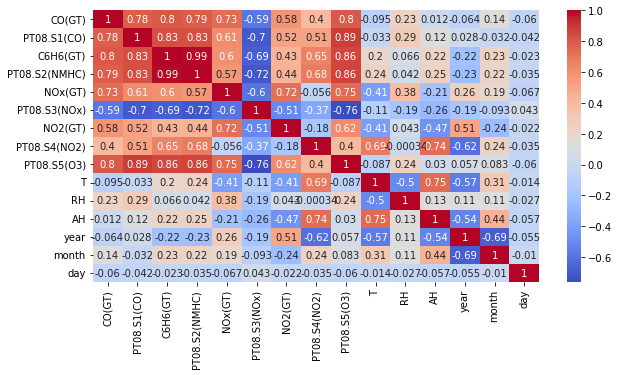

In [19]:
import seaborn as sns
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(),annot = True , cmap = 'coolwarm' );

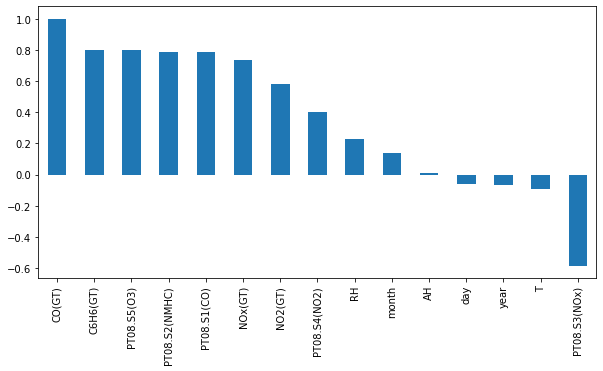

In [20]:
corr_mat = df.corr()
plt.figure(figsize = (10,5))
corr_mat['CO(GT)'].sort_values(ascending = False).plot(kind = 'bar');

In [21]:
df.corr()['CO(GT)'].sort_values(ascending=False).abs()

CO(GT)           1.000000
C6H6(GT)         0.801497
PT08.S5(O3)      0.799460
PT08.S2(NMHC)    0.789460
PT08.S1(CO)      0.784967
NOx(GT)          0.732936
NO2(GT)          0.581823
PT08.S4(NO2)     0.398735
RH               0.228789
month            0.138862
AH               0.011891
day              0.059850
year             0.064402
T                0.095101
PT08.S3(NOx)     0.585400
Name: CO(GT), dtype: float64

In [22]:
del df['AH']

In [23]:
from sklearn import preprocessing
columns = df.columns
for i in columns:
    if df.dtypes[i] is object:
        print("Cannot process object data")
    

## if skew is 0.5 and -0.5 i.e its normal distribution and use scaler else normalise
scale_list = []
normalise_list = []
data_skew = df.skew()

for i in columns:
    if data_skew[i] >= -0.5 and data_skew[i] <= 0.5:
        scale_list.append(i)
    else:
        normalise_list.append(i)
print(scale_list)
print(normalise_list)

['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'T', 'RH', 'hour', 'month', 'day']
['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S5(O3)', 'year']


In [24]:
col_names = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'T', 'RH', 'hour', 'month', 'day']
features = df[col_names]
scaler = preprocessing.StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df[col_names] = features
print(df)

                       CO(GT)  PT08.S1(CO)   C6H6(GT)  PT08.S2(NMHC)  \
date                                                                   
2004-03-10 18:00:00  2.600000     1.630928  11.900000       0.585979   
2004-03-10 19:00:00  2.274072     1.398175  10.541966       0.311140   
2004-03-10 20:00:00  2.245001     1.593386   9.936800       0.185523   
2004-03-10 21:00:00  2.230682     1.637413   9.702345       0.139569   
2004-03-10 22:00:00  2.057541     1.483408   8.823209      -0.058413   
...                       ...          ...        ...            ...   
2005-04-04 10:00:00  2.525947     0.385825   9.752433      -0.147183   
2005-04-04 11:00:00  2.504913     0.386428  10.014567      -0.047342   
2005-04-04 12:00:00  2.487530     0.365881  10.394098       0.068460   
2005-04-04 13:00:00  2.423739     0.209253  10.251844       0.075608   
2005-04-04 14:00:00  2.387111     0.145716  10.514071       0.157695   

                        NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08

In [25]:
col_names = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S5(O3)', 'year']
features = df[col_names]
scaler_1 = preprocessing.MinMaxScaler().fit(features.values)
features = scaler_1.transform(features.values)
df[col_names] = features
print(df)

                       CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
date                                                                            
2004-03-10 18:00:00  0.317504     1.630928  0.311801       0.585979  0.126564   
2004-03-10 19:00:00  0.274973     1.398175  0.272546       0.311140  0.095617   
2004-03-10 20:00:00  0.271180     1.593386  0.255053       0.185523  0.095341   
2004-03-10 21:00:00  0.269311     1.637413  0.248276       0.139569  0.107003   
2004-03-10 22:00:00  0.246718     1.483408  0.222864      -0.058413  0.103684   
...                       ...          ...       ...            ...       ...   
2005-04-04 10:00:00  0.307841     0.385825  0.249724      -0.147183  0.277931   
2005-04-04 11:00:00  0.305096     0.386428  0.257301      -0.047342  0.280753   
2005-04-04 12:00:00  0.302828     0.365881  0.268272       0.068460  0.274493   
2005-04-04 13:00:00  0.294504     0.209253  0.264160       0.075608  0.260884   
2005-04-04 14:00:00  0.28972

In [26]:
df_1 = df.to_numpy()

print(df_1)


[[ 0.31750401  1.63092824  0.31180053 ...  0.         -0.96287933
  -0.66720732]
 [ 0.27497334  1.39817501  0.27254577 ...  0.         -0.96287933
  -0.66720732]
 [ 0.27117989  1.59338642  0.25505309 ...  0.         -0.96287933
  -0.66720732]
 ...
 [ 0.30282767  0.36588136  0.26827156 ...  1.         -0.6720105
  -1.34839214]
 [ 0.29450352  0.20925267  0.26415962 ...  1.         -0.6720105
  -1.34839214]
 [ 0.28972392  0.14571602  0.27173946 ...  1.         -0.6720105
  -1.34839214]]


In [27]:
df_2 = df['CO(GT)'].to_numpy()

print(df_2)

[0.31750401 0.27497334 0.27117989 ... 0.30282767 0.29450352 0.28972392]


In [28]:
'''def createXY(dataset,n_past, horizon):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i+horizon, 0])
    return np.array(dataX),np.array(dataY)

X,Y=createXY(df_1,48,24)'''

'def createXY(dataset,n_past, horizon):\n    dataX = []\n    dataY = []\n    for i in range(n_past, len(dataset)):\n            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])\n            dataY.append(dataset[i+horizon, 0])\n    return np.array(dataX),np.array(dataY)\n\nX,Y=createXY(df_1,48,24)'

In [29]:
def createXY(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon#here try to give end as none because this line of code prevent from index error

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

X,Y=createXY(df_1,df_2,0,None,96,24)
#Here we have to bifurcate data in terms of window size having the large size of window good for accuracy but taking large
#time for computation and horizon is how much data you want to forecast or "y"

In [30]:
X.shape, Y.shape

((9237, 96, 15), (9237, 24))

In [31]:
X[0]

array([[ 0.31750401,  1.63092824,  0.31180053, ...,  0.        ,
        -0.96287933, -0.66720732],
       [ 0.27497334,  1.39817501,  0.27254577, ...,  0.        ,
        -0.96287933, -0.66720732],
       [ 0.27117989,  1.59338642,  0.25505309, ...,  0.        ,
        -0.96287933, -0.66720732],
       ...,
       [ 0.24857177,  1.12817788,  0.20096822, ...,  0.        ,
        -0.96287933, -0.21308411],
       [ 0.26824139,  1.30641493,  0.21860204, ...,  0.        ,
        -0.96287933, -0.21308411],
       [ 0.28255097,  1.43624329,  0.23389015, ...,  0.        ,
        -0.96287933, -0.21308411]])

In [32]:
print(Y[0])
print(Y[1])

[0.3331743  0.39986842 0.40340326 0.37918248 0.36095504 0.33731308
 0.31746779 0.30080474 0.27223343 0.27223343 0.24212552 0.22753733
 0.23418566 0.31410956 0.43720342 0.48746825 0.49395664 0.47551813
 0.45594078 0.43967882 0.41763457 0.39501802 0.3866962  0.44924661]
[0.39986842 0.40340326 0.37918248 0.36095504 0.33731308 0.31746779
 0.30080474 0.27223343 0.27223343 0.24212552 0.22753733 0.23418566
 0.31410956 0.43720342 0.48746825 0.49395664 0.47551813 0.45594078
 0.43967882 0.41763457 0.39501802 0.3866962  0.44924661 0.54150675]


In [33]:
def split_train_test_LSTM(X, y, valid_size, test_size):
  test_split  = int(len(X) * (1-test_size))
  valid_split = int(len(X) * (1-(valid_size+test_size)))

  X_train  = X[:valid_split].copy()
  X_valid  = X[valid_split+1:test_split].copy()
  X_test  = X[test_split+1:].copy()

  y_train  = y[:valid_split].copy()
  y_valid  = y[valid_split+1:test_split].copy()
  y_test  = y[test_split+1:].copy()

  return X_train, y_train, X_valid, y_valid, X_test, y_test

In [34]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split_train_test_LSTM(X, Y, 0.2, 0.1)

In [80]:
model = Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(96,15)))#Here I have given 128 nural network because I have given 16 column as input 
model.add(LSTM(256))#minimum number of neurons should be 16 or atleast multiple of it
model.add(Dropout(0.2))#Dropout is very helpful in dealing with the oversfitting,here it randomly removes 20% of neurons while processing
model.add(Dense(48))
model.add(Dropout(0.2))
model.add(Dense(24))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train, epochs=25, batch_size=50, verbose=2,validation_data=(X_valid,y_valid))

Epoch 1/25
130/130 - 43s - loss: 0.0154 - val_loss: 0.0206 - 43s/epoch - 334ms/step
Epoch 2/25
130/130 - 41s - loss: 0.0090 - val_loss: 0.0177 - 41s/epoch - 314ms/step
Epoch 3/25
130/130 - 41s - loss: 0.0077 - val_loss: 0.0288 - 41s/epoch - 318ms/step
Epoch 4/25
130/130 - 41s - loss: 0.0062 - val_loss: 0.0235 - 41s/epoch - 318ms/step
Epoch 5/25
130/130 - 41s - loss: 0.0051 - val_loss: 0.0202 - 41s/epoch - 318ms/step
Epoch 6/25
130/130 - 41s - loss: 0.0046 - val_loss: 0.0196 - 41s/epoch - 319ms/step
Epoch 7/25
130/130 - 41s - loss: 0.0040 - val_loss: 0.0214 - 41s/epoch - 316ms/step
Epoch 8/25
130/130 - 42s - loss: 0.0034 - val_loss: 0.0180 - 42s/epoch - 321ms/step
Epoch 9/25
130/130 - 42s - loss: 0.0031 - val_loss: 0.0190 - 42s/epoch - 320ms/step
Epoch 10/25
130/130 - 42s - loss: 0.0027 - val_loss: 0.0188 - 42s/epoch - 320ms/step
Epoch 11/25
130/130 - 42s - loss: 0.0024 - val_loss: 0.0180 - 42s/epoch - 319ms/step
Epoch 12/25
130/130 - 41s - loss: 0.0023 - val_loss: 0.0205 - 41s/epoch - 

In [81]:
'''from keras.wrappers.scikit_learn import KerasRegressor

def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(64,return_sequences=True,input_shape=(96,16)))
    grid_model.add(LSTM(128))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(48))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(X_valid,y_valid))
parameters = {'batch_size' : [25],
              'epochs' : [14],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)'''

"from keras.wrappers.scikit_learn import KerasRegressor\n\ndef build_model(optimizer):\n    grid_model = Sequential()\n    grid_model.add(LSTM(64,return_sequences=True,input_shape=(96,16)))\n    grid_model.add(LSTM(128))\n    grid_model.add(Dropout(0.2))\n    grid_model.add(Dense(48))\n\n    grid_model.compile(loss = 'mse',optimizer = optimizer)\n    return grid_model\ngrid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(X_valid,y_valid))\nparameters = {'batch_size' : [25],\n              'epochs' : [14],\n              'optimizer' : ['adam','Adadelta'] }\n\ngrid_search  = GridSearchCV(estimator = grid_model,\n                            param_grid = parameters,\n                            cv = 2)"

In [82]:
'''grid_search = grid_search.fit(X_train,y_train)'''

'grid_search = grid_search.fit(X_train,y_train)'

In [83]:
'''grid_search.best_params_'''

'grid_search.best_params_'

In [84]:
'''my_model=grid_search.best_estimator_.model'''

'my_model=grid_search.best_estimator_.model'

In [85]:
prediction=model.predict(X_test)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

29/29 [==============================] - 3s 91ms/step
prediction
 [[0.14650534 0.1537284  0.1548014  ... 0.21727665 0.20655866 0.20111911]
 [0.1390993  0.15343179 0.16026258 ... 0.20488928 0.1955097  0.19327524]
 [0.140001   0.15946099 0.16915928 ... 0.19448897 0.18824217 0.19028841]
 ...
 [0.0627486  0.07410598 0.09652239 ... 0.270733   0.28651983 0.28521162]
 [0.05273616 0.07629219 0.10952125 ... 0.2680625  0.2644273  0.2518213 ]
 [0.0562333  0.09082066 0.1307763  ... 0.24535398 0.2299226  0.21603954]]

Prediction Shape- (923, 24)


In [86]:
prediction[2,0]

0.140001

In [87]:
Y_test = []
for i in range(0,921):
    Y_test.append(y_test[i,0])
Y_test = np.array(Y_test)
print(y_test)
print(Y_test)

[[0.16796284 0.15266328 0.15640641 ... 0.30018675 0.27171545 0.24571742]
 [0.15266328 0.15640641 0.19553083 ... 0.27171545 0.24571742 0.21971372]
 [0.15640641 0.19553083 0.24302845 ... 0.24571742 0.21971372 0.20202288]
 ...
 [0.10809637 0.10819535 0.11035475 ... 0.30784075 0.30509607 0.30282767]
 [0.10819535 0.11035475 0.11632292 ... 0.30509607 0.30282767 0.29450352]
 [0.11035475 0.11632292 0.12341769 ... 0.30282767 0.29450352 0.28972392]]
[0.16796284 0.15266328 0.15640641 0.19553083 0.24302845 0.25778396
 0.25032348 0.23550899 0.22967411 0.22909888 0.23499937 0.25686566
 0.27512341 0.30933752 0.34006643 0.36370175 0.37513253 0.36171698
 0.34419816 0.33784327 0.32416926 0.30018675 0.27171545 0.24571742
 0.21971372 0.20202288 0.19547277 0.23569996 0.31523546 0.34884446
 0.35839825 0.33319074 0.3203074  0.3115529  0.29588469 0.28686465
 0.28551065 0.29475526 0.31498767 0.34445881 0.33394036 0.33340138
 0.33294817 0.33464339 0.32153481 0.30635956 0.29775149 0.28220817
 0.26083311 0.234554

In [88]:
Pred = []
for i in range(0,921):
    Pred.append(prediction[i,0])
Pred = np.array(Pred)
print(prediction)
print(Pred)

[[0.14650534 0.1537284  0.1548014  ... 0.21727665 0.20655866 0.20111911]
 [0.1390993  0.15343179 0.16026258 ... 0.20488928 0.1955097  0.19327524]
 [0.140001   0.15946099 0.16915928 ... 0.19448897 0.18824217 0.19028841]
 ...
 [0.0627486  0.07410598 0.09652239 ... 0.270733   0.28651983 0.28521162]
 [0.05273616 0.07629219 0.10952125 ... 0.2680625  0.2644273  0.2518213 ]
 [0.0562333  0.09082066 0.1307763  ... 0.24535398 0.2299226  0.21603954]]
[ 0.14650534  0.1390993   0.140001    0.1466951   0.1563403   0.16774535
  0.17870767  0.18579194  0.18821199  0.1880295   0.18906686  0.19373952
  0.20320186  0.21690823  0.23169726  0.2451779   0.2546017   0.258616
  0.25733894  0.2505666   0.2404495   0.2275292   0.20903979  0.19345137
  0.18779717  0.19354333  0.20763749  0.22548234  0.2427427   0.25844654
  0.2695314   0.27200425  0.26766875  0.25988728  0.25171787  0.24953513
  0.25628507  0.2715801   0.29195932  0.31057233  0.31947368  0.31601506
  0.29988587  0.27706122  0.25281253  0.236129 

In [89]:
predictions = np.reshape(Pred, (-1,1 ))
predictions.shape

(921, 1)

In [90]:
prediction_copies = np.repeat(predictions, 7, axis=-1)
print(prediction_copies)

[[0.14650534 0.14650534 0.14650534 ... 0.14650534 0.14650534 0.14650534]
 [0.1390993  0.1390993  0.1390993  ... 0.1390993  0.1390993  0.1390993 ]
 [0.140001   0.140001   0.140001   ... 0.140001   0.140001   0.140001  ]
 ...
 [0.09242287 0.09242287 0.09242287 ... 0.09242287 0.09242287 0.09242287]
 [0.0789036  0.0789036  0.0789036  ... 0.0789036  0.0789036  0.0789036 ]
 [0.0627486  0.0627486  0.0627486  ... 0.0627486  0.0627486  0.0627486 ]]


In [91]:
prediction_copies.shape

(921, 7)

In [92]:
y_pred = scaler_1.inverse_transform(prediction_copies)[:,0]
y_pred

array([1.2895745 , 1.2328193 , 1.2397294 , 1.2910287 , 1.3649434 ,
       1.4523445 , 1.5363528 , 1.5906421 , 1.6091878 , 1.6077894 ,
       1.615739  , 1.6515473 , 1.7240608 , 1.8290976 , 1.9424313 ,
       2.0457385 , 2.1179564 , 2.1487195 , 2.138933  , 2.087034  ,
       2.0095031 , 1.91049   , 1.768799  , 1.6493392 , 1.606009  ,
       1.6500438 , 1.7580526 , 1.8948042 , 2.0270767 , 2.147421  ,
       2.2323682 , 2.2513185 , 2.218094  , 2.1584618 , 2.0958567 ,
       2.0791295 , 2.1308568 , 2.248068  , 2.4042416 , 2.5468798 ,
       2.6150942 , 2.5885897 , 2.4649856 , 2.290072  , 2.1042454 ,
       1.9763935 , 1.8279834 , 1.723621  , 1.7568558 , 2.0116696 ,
       2.43701   , 2.7455103 , 2.858899  , 2.8263762 , 2.6233835 ,
       2.2563932 , 1.9561725 , 1.7540319 , 1.6441915 , 1.5698866 ,
       1.4919814 , 1.413005  , 1.3475603 , 1.2968715 , 1.2586038 ,
       1.2430401 , 1.2404028 , 1.2454839 , 1.2658067 , 1.2818179 ,
       1.2710263 , 1.2560325 , 1.2677903 , 1.3153678 , 1.37469

In [93]:
y_pred.shape


(921,)

In [94]:
Y_test.shape

(921,)

In [95]:
Y_test = np.reshape(Y_test, (-1,1 ))

In [96]:
Y_test.shape

(921, 1)

In [97]:
y_test_copies = np.repeat(Y_test, 7, axis=-1)
#print(y_test)
y_test_copies.shape

(921, 7)

In [98]:
Y_test = scaler_1.inverse_transform(y_test_copies)[:,0]
Y_test

array([1.45401114, 1.336765  , 1.36544999, 1.66527481, 2.02926649,
       2.14234337, 2.08517095, 1.97164206, 1.92692724, 1.92251903,
       1.96773669, 2.13530611, 2.27522193, 2.53741718, 2.7729041 ,
       2.95403022, 3.04162845, 2.93882017, 2.80456707, 2.75586722,
       2.65107828, 2.46729145, 2.24910544, 2.049873  , 1.85059714,
       1.71502577, 1.66482984, 1.97310554, 2.58261525, 2.84017334,
       2.91338752, 2.72021316, 2.62148342, 2.55439442, 2.43432319,
       2.36519933, 2.35482317, 2.42566797, 2.58071634, 2.80656455,
       2.72595778, 2.72182735, 2.71835422, 2.73134537, 2.63088949,
       2.51459597, 2.44862921, 2.329515  , 2.16571012, 1.96432557,
       1.81089437, 1.68187566, 1.65293812, 1.62860478, 1.59223252,
       1.72075247, 1.89246603, 2.05276939, 2.13983625, 2.19713987,
       2.27714705, 2.36033511, 2.46210838, 2.65906185, 2.7928584 ,
       2.95309851, 3.16739568, 3.42714919, 3.55011265, 3.5103188 ,
       3.42912519, 3.42912519, 2.98294864, 2.60953347, 2.34426

In [99]:
Y_test.shape

(921,)

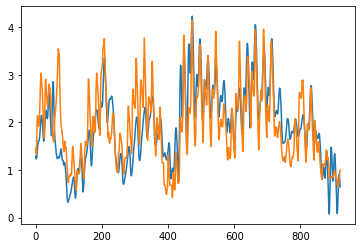

In [100]:
  df = pd.DataFrame(data={'Predictions': y_pred,
                          'Actuals':Y_test
                          })
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])

In [101]:
from sklearn.metrics import explained_variance_score,mean_squared_error, r2_score,max_error, mean_absolute_error, mean_absolute_percentage_error
def model_evaluate(model, y_test, y_pred):
  exp_var_score = explained_variance_score(y_test, y_pred)
  max_err= max_error(y_test, y_pred)
  r2= r2_score(y_test, y_pred)
  mae= mean_absolute_error(y_test, y_pred)
  mse= mean_squared_error(y_test, y_pred)
  rmse= np.sqrt(mse)
  mape = mean_absolute_percentage_error(y_test, y_pred)

  row_label = [model]
  
  data_score = { 'exp_varne': exp_var_score, 'max_error':max_err, 
                'r2': r2, 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape,}
  
  df_data = pd.DataFrame(data= data_score, index= row_label)
  
  return df_data

In [102]:
model_evaluate('LSTM',df['Actuals'], df['Predictions'])

,exp_varne,max_error,r2,mae,mse,rmse,mape
LSTM,0.533163,2.284306,0.532439,0.420922,0.282573,0.531576,0.247648


In [90]:
df_1.shape

(9357, 16)

In [91]:
print(y_test[-48:-1])

[1.37298245 1.39319148 1.50564763 1.6002115  1.58426745 1.49130822
 1.38131841 1.28882843 1.19514361 1.10045403 1.00491956 0.92458499
 0.92458499 0.84659812 0.80238989 0.92497963 1.09351631 1.12872381
 1.10702266 1.08914954 1.0909474  1.12535941 1.10483707 1.10404883
 1.15209119 1.2083862  1.27158208 1.4210644  1.41767932 1.33462015
 1.24895783 1.22511715 1.26907053 1.24205786 1.13954374 1.03748833
 0.93580887 0.85038118 0.81047448 0.8247394  0.83672853 0.83087878
 0.85781024 0.84860562 0.84086748 0.86619928 0.8556621 ]


In [92]:
print(y_pred[-48:-1])

[2.2757452  2.111414   1.9251608  1.7405586  1.5691986  1.4187905
 1.2740631  1.1266301  0.98355716 0.85494626 0.70572263 0.5801386
 0.5321289  0.58809215 0.74804157 0.9880855  1.2694316  1.5608559
 1.8228033  2.0139642  2.1161802  2.1354463  2.09591    2.0253608
 1.936802   1.8417671  1.7501906  1.6657459  1.5851226  1.5105556
 1.42132    1.30948    1.1851085  1.064287   0.87854296 0.72513264
 0.653317   0.70069724 0.8682295  1.1295401  1.4356129  1.7116896
 1.8800024  1.9224154  1.8781207  1.8105803  1.7752439 ]


In [93]:
y_pred_48 = y_pred[-48:-1]
y_pred_48

array([2.2757452 , 2.111414  , 1.9251608 , 1.7405586 , 1.5691986 ,
       1.4187905 , 1.2740631 , 1.1266301 , 0.98355716, 0.85494626,
       0.70572263, 0.5801386 , 0.5321289 , 0.58809215, 0.74804157,
       0.9880855 , 1.2694316 , 1.5608559 , 1.8228033 , 2.0139642 ,
       2.1161802 , 2.1354463 , 2.09591   , 2.0253608 , 1.936802  ,
       1.8417671 , 1.7501906 , 1.6657459 , 1.5851226 , 1.5105556 ,
       1.42132   , 1.30948   , 1.1851085 , 1.064287  , 0.87854296,
       0.72513264, 0.653317  , 0.70069724, 0.8682295 , 1.1295401 ,
       1.4356129 , 1.7116896 , 1.8800024 , 1.9224154 , 1.8781207 ,
       1.8105803 , 1.7752439 ], dtype=float32)

In [96]:
y_pred_24 = [1.4951963,1.4553288,1.4513407,1.4898683,1.5658625,1.6581508
,1.7374805,1.7876123,1.7753762,1.6988387,1.582298,1.4581307
,1.2362357,1.0777462,0.9958036,1.0120819,1.1239418,1.3037927
,1.5023454,1.6651262 , 1.7465104 , 1.7433046 , 1.6816176 , 1.5950084
,1.5141155, 1.4663817 , 1.4658461 , 1.5161699 , 1.6054797 , 1.7080142
,1.790251  , 1.8231183 , 1.7936032 , 1.7029518 , 1.5714035 , 1.425104
,1.1664006  ,0.9761648 , 0.87517995 ,0.89312357 ,1.0244597 , 1.2264134
,1.4423909  ,1.616223 ,  1.7116017 , 1.7320276 , 1.6930618 ]

y_pred_24 = np.array(y_pred_24)
y_pred_24

array([1.4951963 , 1.4553288 , 1.4513407 , 1.4898683 , 1.5658625 ,
       1.6581508 , 1.7374805 , 1.7876123 , 1.7753762 , 1.6988387 ,
       1.582298  , 1.4581307 , 1.2362357 , 1.0777462 , 0.9958036 ,
       1.0120819 , 1.1239418 , 1.3037927 , 1.5023454 , 1.6651262 ,
       1.7465104 , 1.7433046 , 1.6816176 , 1.5950084 , 1.5141155 ,
       1.4663817 , 1.4658461 , 1.5161699 , 1.6054797 , 1.7080142 ,
       1.790251  , 1.8231183 , 1.7936032 , 1.7029518 , 1.5714035 ,
       1.425104  , 1.1664006 , 0.9761648 , 0.87517995, 0.89312357,
       1.0244597 , 1.2264134 , 1.4423909 , 1.616223  , 1.7116017 ,
       1.7320276 , 1.6930618 ])

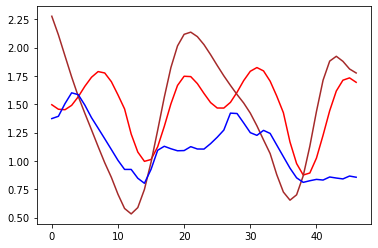

In [98]:
plt.plot(y_pred_24, color='red')
plt.plot(y_pred_48, color='brown')
plt.plot(y_test[-48:-1], color='blue')

In [58]:
df_3 = df_1[9165:9357,0:16]

In [59]:
df_3.shape

(192, 16)

In [60]:
def createX(dataset, start, end, window):
    X = []
    start = start + window
    

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        
    return np.array(X)

X_hat=createX(df_3,0,192,96)

In [61]:
X_hat.shape

(96, 96, 16)

In [62]:
X_hat.shape

(96, 96, 16)

In [63]:
forecast=my_model.predict(X_hat)
print("prediction\n", forecast)
print("\nPrediction Shape-",forecast.shape)

3/3 [==============================] - 0s 35ms/step
prediction
 [[0.29800308 0.33126324 0.36949265 ... 0.3318435  0.3226735  0.33821154]
 [0.31005895 0.3519556  0.38770384 ... 0.34023193 0.33584112 0.3594438 ]
 [0.3209846  0.36506844 0.39223152 ... 0.3521196  0.35452536 0.38350713]
 ...
 [0.16961984 0.14556909 0.14479668 ... 0.40381023 0.4101914  0.40626565]
 [0.1621048  0.14924614 0.16564389 ... 0.43239802 0.42706722 0.41995847]
 [0.15705964 0.16125467 0.19554047 ... 0.44383264 0.4323081  0.43098775]]

Prediction Shape- (96, 48)


In [64]:
forecasts = np.reshape(forecast, (4608,1 ))
print(forecasts.shape)
prediction_copies = np.repeat(forecasts, 7, axis=-1)
print(prediction_copies)
y_forecast = scaler_1.inverse_transform(prediction_copies)[:,0]
y_forecast

(4608, 1)
[[0.29800308 0.29800308 0.29800308 ... 0.29800308 0.29800308 0.29800308]
 [0.33126324 0.33126324 0.33126324 ... 0.33126324 0.33126324 0.33126324]
 [0.36949265 0.36949265 0.36949265 ... 0.36949265 0.36949265 0.36949265]
 ...
 [0.44383264 0.44383264 0.44383264 ... 0.44383264 0.44383264 0.44383264]
 [0.4323081  0.4323081  0.4323081  ... 0.4323081  0.4323081  0.4323081 ]
 [0.43098775 0.43098775 0.43098775 ... 0.43098775 0.43098775 0.43098775]]


array([2.4505572, 2.705442 , 2.9984078, ..., 3.5681026, 3.479786 ,
       3.4696674], dtype=float32)

In [67]:
print(y_forecast[4559:4608])

[3.3851461 1.370456  1.4026041 1.6653488 1.836075  2.079472  2.1336553
 2.233509  2.1394114 1.937892  1.7531    1.4416631 1.2250034 1.0433557
 1.077359  1.2432754 1.4698089 1.7777544 2.138881  2.402276  2.4944744
 2.541458  2.4170618 2.331848  2.2245018 2.2793999 2.45421   2.7263849
 3.0036755 3.2962472 3.4048786 3.5652463 3.4920216 3.1958466 2.871715
 2.5011752 2.2651527 2.062498  1.9762595 2.161842  2.4995856 2.8303971
 3.1761706 3.412592  3.596498  3.6799524 3.5681026 3.479786  3.4696674]


In [75]:
a = [2.4101315,2.4819665,2.5395575,2.6317186,2.7708576,2.8797047,2.781817
,2.5313988,2.398239,2.0534549,1.717107,1.5877234,1.6392248,1.7404652
 ,1.9245359,2.067982,2.4241812,2.8217752,3.0476987,3.111661,3.1507003
,3.1097472,3.0689533]
b = [1.370456,1.4026041,1.6653488,1.836075,2.079472,2.1336553,2.233509
,2.1394114,1.937892,1.7531,1.4416631,1.2250034,1.0433557,1.077359
,1.2432754,1.4698089,1.7777544,2.138881,2.402276,2.4944744,2.541458
,2.4170618,2.331848] 
a = np.array(a)
b = np.array(b)

In [76]:
mape = np.mean(np.abs((a - b) / b)) * 100
print(mape)

37.7229145826837


In [8]:
df = pd.read_csv("AirQualityUCI.csv")
df = df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1)
null_data = df[df.isnull().any(axis=1)]
df = df.dropna()
df = df.replace(-200, np.nan)
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
h = df['Time'].tolist()
l=[]
for i in range(len(h)):
    l.append(h[i].split(":")[0])
df['hour']=l
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
cols=["year","month","day","hour"]
df['date'] = df[cols].apply(lambda x: '/'.join(x.values.astype(str)), axis="columns")
df['date']=pd.to_datetime(df['date'])
del df['Date']
del df['Time']
df.set_index('date', inplace=True)
del df['NMHC(GT)']

In [9]:
df['CO(GT)'] = df['CO(GT)'].ewm(halflife=4).mean()
df['PT08.S1(CO)'] = df['PT08.S1(CO)'].ewm(halflife=4).mean()
df['C6H6(GT)'] = df['C6H6(GT)'].ewm(halflife=4).mean()
df['PT08.S2(NMHC)'] = df['PT08.S2(NMHC)'].ewm(halflife=4).mean()
df['NOx(GT)'] = df['NOx(GT)'].ewm(halflife=4).mean()
df['PT08.S3(NOx)'] = df['PT08.S3(NOx)'].ewm(halflife=4).mean()
df['NO2(GT)'] = df['NO2(GT)'].ewm(halflife=4).mean()
df['PT08.S4(NO2)'] = df['PT08.S4(NO2)'].ewm(halflife=4).mean()
df['PT08.S5(O3)'] = df['PT08.S5(O3)'].ewm(halflife=4).mean()
df['T'] = df['T'].ewm(halflife=4).mean()
df['RH'] = df['RH'].ewm(halflife=4).mean()
df['AH'] = df['AH'].ewm(halflife=4).mean()

In [10]:
df.isnull().sum()
df.corr()['C6H6(GT)'].sort_values(ascending=False).abs()

C6H6(GT)         1.000000
PT08.S2(NMHC)    0.988204
PT08.S5(O3)      0.859145
PT08.S1(CO)      0.827818
CO(GT)           0.801497
PT08.S4(NO2)     0.652433
NOx(GT)          0.600687
NO2(GT)          0.431635
month            0.225716
AH               0.223426
T                0.200614
RH               0.065767
day              0.023271
year             0.217012
PT08.S3(NOx)     0.685664
Name: C6H6(GT), dtype: float64

In [11]:
from sklearn import preprocessing
col_names = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'T', 'RH', 'AH', 'hour', 'month', 'day']
features = df[col_names]
scaler = preprocessing.StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df[col_names] = features
print(df)

                       CO(GT)  PT08.S1(CO)   C6H6(GT)  PT08.S2(NMHC)  \
date                                                                   
2004-03-10 18:00:00  2.600000     1.630928  11.900000       0.585979   
2004-03-10 19:00:00  2.274072     1.398175  10.541966       0.311140   
2004-03-10 20:00:00  2.245001     1.593386   9.936800       0.185523   
2004-03-10 21:00:00  2.230682     1.637413   9.702345       0.139569   
2004-03-10 22:00:00  2.057541     1.483408   8.823209      -0.058413   
...                       ...          ...        ...            ...   
2005-04-04 10:00:00  2.525947     0.385825   9.752433      -0.147183   
2005-04-04 11:00:00  2.504913     0.386428  10.014567      -0.047342   
2005-04-04 12:00:00  2.487530     0.365881  10.394098       0.068460   
2005-04-04 13:00:00  2.423739     0.209253  10.251844       0.075608   
2005-04-04 14:00:00  2.387111     0.145716  10.514071       0.157695   

                        NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08

In [12]:
col_names = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S5(O3)', 'year']
features = df[col_names]
scaler_1 = preprocessing.MinMaxScaler().fit(features.values)
features = scaler_1.transform(features.values)
df[col_names] = features
print(df)

                       CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
date                                                                            
2004-03-10 18:00:00  0.317504     1.630928  0.311801       0.585979  0.126564   
2004-03-10 19:00:00  0.274973     1.398175  0.272546       0.311140  0.095617   
2004-03-10 20:00:00  0.271180     1.593386  0.255053       0.185523  0.095341   
2004-03-10 21:00:00  0.269311     1.637413  0.248276       0.139569  0.107003   
2004-03-10 22:00:00  0.246718     1.483408  0.222864      -0.058413  0.103684   
...                       ...          ...       ...            ...       ...   
2005-04-04 10:00:00  0.307841     0.385825  0.249724      -0.147183  0.277931   
2005-04-04 11:00:00  0.305096     0.386428  0.257301      -0.047342  0.280753   
2005-04-04 12:00:00  0.302828     0.365881  0.268272       0.068460  0.274493   
2005-04-04 13:00:00  0.294504     0.209253  0.264160       0.075608  0.260884   
2005-04-04 14:00:00  0.28972

In [97]:
c = df.columns
df[[c[0], c[2]]] = df[[c[2], c[0]]]
df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day
date,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,0.311801,1.630928,0.317504,0.585979,0.126564,0.368408,0.347459,0.832721,0.492804,-0.566479,-0.010299,-0.657990,0.939133,0.0,-0.962879,-0.667207
2004-03-10 19:00:00,0.272546,1.398175,0.274973,0.311140,0.095617,0.404872,0.301885,0.582103,0.409136,-0.586400,-0.055889,-0.702414,1.083583,0.0,-0.962879,-0.667207
2004-03-10 20:00:00,0.255053,1.593386,0.271180,0.185523,0.095341,0.409315,0.321339,0.493948,0.402354,-0.660142,0.101989,-0.692531,1.228033,0.0,-0.962879,-0.667207
2004-03-10 21:00:00,0.248276,1.637413,0.269311,0.139569,0.107003,0.402815,0.341092,0.482535,0.420373,-0.731474,0.313287,-0.658257,1.372483,0.0,-0.962879,-0.667207
2004-03-10 22:00:00,0.222864,1.483408,0.246718,-0.058413,0.103684,0.416639,0.346131,0.386305,0.417687,-0.766721,0.429894,-0.636636,1.516933,0.0,-0.962879,-0.667207


In [98]:
col_list = list(df)
# use this handy way to swap the elements
col_list[0], col_list[2] = col_list[2], col_list[0]
# assign back, the order will now be swapped
df.columns = col_list
df.head()

,C6H6(GT),PT08.S1(CO),CO(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day
date,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,0.311801,1.630928,0.317504,0.585979,0.126564,0.368408,0.347459,0.832721,0.492804,-0.566479,-0.010299,-0.657990,0.939133,0.0,-0.962879,-0.667207
2004-03-10 19:00:00,0.272546,1.398175,0.274973,0.311140,0.095617,0.404872,0.301885,0.582103,0.409136,-0.586400,-0.055889,-0.702414,1.083583,0.0,-0.962879,-0.667207
2004-03-10 20:00:00,0.255053,1.593386,0.271180,0.185523,0.095341,0.409315,0.321339,0.493948,0.402354,-0.660142,0.101989,-0.692531,1.228033,0.0,-0.962879,-0.667207
2004-03-10 21:00:00,0.248276,1.637413,0.269311,0.139569,0.107003,0.402815,0.341092,0.482535,0.420373,-0.731474,0.313287,-0.658257,1.372483,0.0,-0.962879,-0.667207
2004-03-10 22:00:00,0.222864,1.483408,0.246718,-0.058413,0.103684,0.416639,0.346131,0.386305,0.417687,-0.766721,0.429894,-0.636636,1.516933,0.0,-0.962879,-0.667207


In [99]:
df_1 = df.to_numpy()
df

,C6H6(GT),PT08.S1(CO),CO(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day
date,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,0.311801,1.630928,0.317504,0.585979,0.126564,0.368408,0.347459,0.832721,0.492804,-0.566479,-0.010299,-0.657990,0.939133,0.0,-0.962879,-0.667207
2004-03-10 19:00:00,0.272546,1.398175,0.274973,0.311140,0.095617,0.404872,0.301885,0.582103,0.409136,-0.586400,-0.055889,-0.702414,1.083583,0.0,-0.962879,-0.667207
2004-03-10 20:00:00,0.255053,1.593386,0.271180,0.185523,0.095341,0.409315,0.321339,0.493948,0.402354,-0.660142,0.101989,-0.692531,1.228033,0.0,-0.962879,-0.667207
2004-03-10 21:00:00,0.248276,1.637413,0.269311,0.139569,0.107003,0.402815,0.341092,0.482535,0.420373,-0.731474,0.313287,-0.658257,1.372483,0.0,-0.962879,-0.667207
2004-03-10 22:00:00,0.222864,1.483408,0.246718,-0.058413,0.103684,0.416639,0.346131,0.386305,0.417687,-0.766721,0.429894,-0.636636,1.516933,0.0,-0.962879,-0.667207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,0.249724,0.385825,0.307841,-0.147183,0.277931,0.162920,0.426033,-0.619205,0.446355,-0.364821,-0.179524,-0.668696,-0.216467,1.0,-0.672011,-1.348392
2005-04-04 11:00:00,0.257301,0.386428,0.305096,-0.047342,0.280753,0.154704,0.455484,-0.624416,0.453828,-0.188797,-0.433011,-0.685483,-0.072017,1.0,-0.672011,-1.348392
2005-04-04 12:00:00,0.268272,0.365881,0.302828,0.068460,0.274493,0.147705,0.477707,-0.641493,0.445458,0.009790,-0.706255,-0.728320,0.072433,1.0,-0.672011,-1.348392


In [100]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

X,Y=createXY(df_1,48)
def split_train_test_LSTM(X, y, valid_size, test_size):
  test_split  = int(len(X) * (1-test_size))
  valid_split = int(len(X) * (1-(valid_size+test_size)))

  X_train  = X[:valid_split].copy()
  X_valid  = X[valid_split+1:test_split].copy()
  X_test  = X[test_split+1:].copy()

  y_train  = y[:valid_split].copy()
  y_valid  = y[valid_split+1:test_split].copy()
  y_test  = y[test_split+1:].copy()

  return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = split_train_test_LSTM(X, Y, 0.2, 0.1)

In [101]:
from keras.wrappers.scikit_learn import KerasRegressor

def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(64,return_sequences=True,input_shape=(48,16)))
    grid_model.add(LSTM(128))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(X_valid,y_valid))
parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

grid_search = grid_search.fit(X_train,y_train)

Epoch 1/8
204/204 [==============================] - 70s 303ms/step - loss: 0.0079 - val_loss: 0.0785
Epoch 2/8
204/204 [==============================] - 59s 289ms/step - loss: 0.0032 - val_loss: 0.0528
Epoch 3/8
204/204 [==============================] - 57s 278ms/step - loss: 0.0024 - val_loss: 0.0406
Epoch 4/8
204/204 [==============================] - 58s 285ms/step - loss: 0.0017 - val_loss: 0.0425
Epoch 5/8
204/204 [==============================] - 56s 276ms/step - loss: 0.0013 - val_loss: 0.0334
Epoch 6/8
204/204 [==============================] - 56s 276ms/step - loss: 0.0010 - val_loss: 0.0377
Epoch 7/8
204/204 [==============================] - 57s 278ms/step - loss: 9.7644e-04 - val_loss: 0.0313
Epoch 8/8
204/204 [==============================] - 17s 84ms/step - loss: 0.0081
Epoch 1/8
204/204 [==============================] - 80s 341ms/step - loss: 0.0060 - val_loss: 0.0188
Epoch 2/8
204/204 [==============================] - 64s 315ms/step - loss: 0.0026 - val_loss: 0.0

In [102]:
grid_search.best_params_


{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}

In [103]:
my_model=grid_search.best_estimator_.model

In [104]:
prediction=my_model.predict(X_test)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)
prediction_copies = np.repeat(prediction, 7, axis=-1)
print(prediction_copies)
y_pred = scaler_1.inverse_transform(prediction_copies)[:,0]
print(y_pred)
y_test = np.reshape(y_test, (-1, 1))
y_test_copies = np.repeat(y_test, 7, axis=-1)
#print(y_test)
print(y_test_copies.shape)
y_test = scaler_1.inverse_transform(y_test_copies)[:,0]
y_test

30/30 [==============================] - 1s 26ms/step
prediction
 [[ 0.3235194 ]
 [ 0.31917754]
 [ 0.2837541 ]
 [ 0.26354867]
 [ 0.25504416]
 [ 0.2307857 ]
 [ 0.20085034]
 [ 0.17025416]
 [ 0.15511188]
 [ 0.13087063]
 [ 0.13476501]
 [ 0.14676988]
 [ 0.23581289]
 [ 0.31852093]
 [ 0.31070465]
 [ 0.29708862]
 [ 0.25490516]
 [ 0.25242966]
 [ 0.24077496]
 [ 0.227259  ]
 [ 0.225238  ]
 [ 0.22517943]
 [ 0.24292833]
 [ 0.252396  ]
 [ 0.26464117]
 [ 0.23992237]
 [ 0.24324165]
 [ 0.23880595]
 [ 0.2382533 ]
 [ 0.21429873]
 [ 0.19685903]
 [ 0.1935257 ]
 [ 0.18151796]
 [ 0.15823492]
 [ 0.13395734]
 [ 0.10836007]
 [ 0.10972588]
 [ 0.10725322]
 [ 0.09872031]
 [ 0.09006619]
 [ 0.08815472]
 [ 0.08921848]
 [ 0.08746758]
 [ 0.075365  ]
 [ 0.06902164]
 [ 0.07013869]
 [ 0.07243875]
 [ 0.07881778]
 [ 0.10888603]
 [ 0.12028993]
 [ 0.13121049]
 [ 0.15094812]
 [ 0.18427789]
 [ 0.1868185 ]
 [ 0.16285212]
 [ 0.15518326]
 [ 0.1443931 ]
 [ 0.12050765]
 [ 0.11211854]
 [ 0.1072765 ]
 [ 0.10237628]
 [ 0.09703125]
 [ 0

array([2.77820763, 2.6195472 , 2.46850837, 2.34854909, 2.21243209,
       2.03100879, 1.81501196, 1.633381  , 1.43483139, 1.3383591 ,
       1.32772326, 1.76285002, 2.45298842, 2.67736214, 2.65457511,
       2.45214642, 2.3453635 , 2.22737517, 2.0964399 , 2.02862931,
       1.98922948, 2.08649992, 2.18591613, 2.30475854, 2.21085245,
       2.24114257, 2.22784538, 2.17084702, 2.05242995, 1.93875598,
       1.85374106, 1.72938679, 1.56842784, 1.40135872, 1.23267595,
       1.16131858, 1.10836316, 1.04973566, 0.99691164, 0.97011395,
       0.96167734, 0.95458303, 0.89222756, 0.8468418 , 0.83687202,
       0.83906158, 0.87614645, 1.0835494 , 1.18394206, 1.28245936,
       1.44283831, 1.60589534, 1.67252204, 1.58052474, 1.52078637,
       1.42826018, 1.28349224, 1.17585486, 1.08886735, 1.02981734,
       0.98368676, 1.04005367, 1.04515998, 1.00363707, 0.97576934,
       0.89594558, 0.81824896, 0.75643851, 0.7079867 , 0.68486559,
       0.73591049, 0.84579696, 0.80779848, 0.74060201, 0.74753

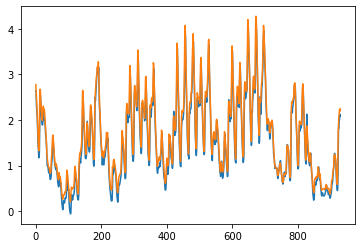

In [105]:
  ddf = pd.DataFrame(data={'Predictions': y_pred,
                          'Actuals':y_test
                          })
  plt.plot(ddf['Predictions'])
  plt.plot(ddf['Actuals'])

In [1]:
model_evaluate('LSTM',ddf['Actuals'], ddf['Predictions'])

NameError: name 'model_evaluate' is not defined

In [13]:
c = df.columns
df[[c[0], c[4]]] = df[[c[4], c[0]]]
df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day
date,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,0.126564,1.630928,0.311801,0.585979,0.317504,0.368408,0.347459,0.832721,0.492804,-0.566479,-0.010299,-0.657990,0.939133,0.0,-0.962879,-0.667207
2004-03-10 19:00:00,0.095617,1.398175,0.272546,0.311140,0.274973,0.404872,0.301885,0.582103,0.409136,-0.586400,-0.055889,-0.702414,1.083583,0.0,-0.962879,-0.667207
2004-03-10 20:00:00,0.095341,1.593386,0.255053,0.185523,0.271180,0.409315,0.321339,0.493948,0.402354,-0.660142,0.101989,-0.692531,1.228033,0.0,-0.962879,-0.667207
2004-03-10 21:00:00,0.107003,1.637413,0.248276,0.139569,0.269311,0.402815,0.341092,0.482535,0.420373,-0.731474,0.313287,-0.658257,1.372483,0.0,-0.962879,-0.667207
2004-03-10 22:00:00,0.103684,1.483408,0.222864,-0.058413,0.246718,0.416639,0.346131,0.386305,0.417687,-0.766721,0.429894,-0.636636,1.516933,0.0,-0.962879,-0.667207


In [14]:
col_list = list(df)
# use this handy way to swap the elements
col_list[0], col_list[4] = col_list[4], col_list[0]
# assign back, the order will now be swapped
df.columns = col_list
df.head()

,NOx(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),CO(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day
date,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,0.126564,1.630928,0.311801,0.585979,0.317504,0.368408,0.347459,0.832721,0.492804,-0.566479,-0.010299,-0.657990,0.939133,0.0,-0.962879,-0.667207
2004-03-10 19:00:00,0.095617,1.398175,0.272546,0.311140,0.274973,0.404872,0.301885,0.582103,0.409136,-0.586400,-0.055889,-0.702414,1.083583,0.0,-0.962879,-0.667207
2004-03-10 20:00:00,0.095341,1.593386,0.255053,0.185523,0.271180,0.409315,0.321339,0.493948,0.402354,-0.660142,0.101989,-0.692531,1.228033,0.0,-0.962879,-0.667207
2004-03-10 21:00:00,0.107003,1.637413,0.248276,0.139569,0.269311,0.402815,0.341092,0.482535,0.420373,-0.731474,0.313287,-0.658257,1.372483,0.0,-0.962879,-0.667207
2004-03-10 22:00:00,0.103684,1.483408,0.222864,-0.058413,0.246718,0.416639,0.346131,0.386305,0.417687,-0.766721,0.429894,-0.636636,1.516933,0.0,-0.962879,-0.667207


In [15]:
df_1 = df.to_numpy()
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

X,Y=createXY(df_1,48)
def split_train_test_LSTM(X, y, valid_size, test_size):
  test_split  = int(len(X) * (1-test_size))
  valid_split = int(len(X) * (1-(valid_size+test_size)))

  X_train  = X[:valid_split].copy()
  X_valid  = X[valid_split+1:test_split].copy()
  X_test  = X[test_split+1:].copy()

  y_train  = y[:valid_split].copy()
  y_valid  = y[valid_split+1:test_split].copy()
  y_test  = y[test_split+1:].copy()

  return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = split_train_test_LSTM(X, Y, 0.2, 0.1)

In [16]:
from keras.wrappers.scikit_learn import KerasRegressor

def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(64,return_sequences=True,input_shape=(48,16)))
    grid_model.add(LSTM(128))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(X_valid,y_valid))
parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

grid_search = grid_search.fit(X_train,y_train)

Epoch 1/8
204/204 [==============================] - 11s 38ms/step - loss: 0.0072 - val_loss: 0.0108
Epoch 2/8
204/204 [==============================] - 7s 35ms/step - loss: 0.0033 - val_loss: 0.0068
Epoch 3/8
204/204 [==============================] - 7s 35ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 4/8
204/204 [==============================] - 7s 36ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 5/8
204/204 [==============================] - 7s 36ms/step - loss: 0.0019 - val_loss: 0.0064
Epoch 6/8
204/204 [==============================] - 7s 36ms/step - loss: 0.0016 - val_loss: 0.0100
Epoch 7/8
204/204 [==============================] - 8s 37ms/step - loss: 0.0014 - val_loss: 0.0072
Epoch 8/8
204/204 [==============================] - 2s 10ms/step - loss: 0.0044
Epoch 1/8
204/204 [==============================] - 11s 41ms/step - loss: 0.0028 - val_loss: 0.0548
Epoch 2/8
204/204 [==============================] - 8s 38ms/step - loss: 7.8739e-04 - val_loss: 0.0351
Epoch 3/8
204

In [17]:
grid_search.best_params_

{'batch_size': 20, 'epochs': 10, 'optimizer': 'adam'}

In [18]:
my_model=grid_search.best_estimator_.model

In [19]:
prediction=my_model.predict(X_test)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)
prediction_copies = np.repeat(prediction, 7, axis=-1)
print(prediction_copies)
y_pred = scaler_1.inverse_transform(prediction_copies)[:,0]
print(y_pred)
y_test = np.reshape(y_test, (-1, 1))
y_test_copies = np.repeat(y_test, 7, axis=-1)
#print(y_test)
print(y_test_copies.shape)
y_test = scaler_1.inverse_transform(y_test_copies)[:,0]
y_test

30/30 [==============================] - 1s 22ms/step
prediction
 [[ 0.33603728]
 [ 0.34154218]
 [ 0.32375205]
 [ 0.30343446]
 [ 0.27136815]
 [ 0.2460073 ]
 [ 0.21385261]
 [ 0.19496107]
 [ 0.1658166 ]
 [ 0.13537991]
 [ 0.12492648]
 [ 0.13102269]
 [ 0.16545057]
 [ 0.20699966]
 [ 0.2279436 ]
 [ 0.2337166 ]
 [ 0.20767921]
 [ 0.1940355 ]
 [ 0.18311729]
 [ 0.1704424 ]
 [ 0.16403499]
 [ 0.16170985]
 [ 0.16951108]
 [ 0.18175685]
 [ 0.19871551]
 [ 0.19688445]
 [ 0.2061738 ]
 [ 0.21655264]
 [ 0.21060354]
 [ 0.19878793]
 [ 0.18244396]
 [ 0.1774422 ]
 [ 0.16430697]
 [ 0.1418016 ]
 [ 0.11671944]
 [ 0.09425923]
 [ 0.08414323]
 [ 0.08120106]
 [ 0.07787945]
 [ 0.07246244]
 [ 0.06903564]
 [ 0.06836054]
 [ 0.06769606]
 [ 0.06318167]
 [ 0.05778243]
 [ 0.05701755]
 [ 0.06039197]
 [ 0.06788999]
 [ 0.08507588]
 [ 0.09932797]
 [ 0.11459336]
 [ 0.1333333 ]
 [ 0.14830077]
 [ 0.157422  ]
 [ 0.14713548]
 [ 0.13998927]
 [ 0.12874416]
 [ 0.10479294]
 [ 0.08458503]
 [ 0.07564843]
 [ 0.07271458]
 [ 0.07141112]
 [ 0

array([3.369134  , 3.25472878, 3.08448132, 2.98364993, 2.86579157,
       2.66396121, 2.66396121, 2.31895847, 2.04933231, 1.96432747,
       1.98541294, 1.98541294, 1.98541294, 2.361243  , 2.76022826,
       2.61782792, 2.53399945, 2.45303315, 2.32350106, 2.27273578,
       2.22811827, 2.26324255, 2.34603476, 2.47804116, 2.47394563,
       2.60448384, 2.72304119, 2.77748399, 2.74393485, 2.65641144,
       2.65641144, 2.45961036, 2.21321032, 1.98642749, 1.8117369 ,
       1.71487632, 1.68852504, 1.63895869, 1.57039728, 1.50449748,
       1.46119022, 1.41838354, 1.35228684, 1.27916593, 1.25167327,
       1.25437302, 1.31125446, 1.40452613, 1.47937194, 1.60761535,
       1.73294755, 1.99431577, 2.12077278, 2.06214998, 2.06214998,
       1.90193402, 1.69224764, 1.52247936, 1.48209807, 1.49294177,
       1.48194987, 1.54471449, 1.51843571, 1.45785289, 1.43363629,
       1.3660314 , 1.2556531 , 1.20051593, 1.172327  , 1.1911501 ,
       1.28042416, 1.43306921, 1.46554133, 1.3707627 , 1.33666

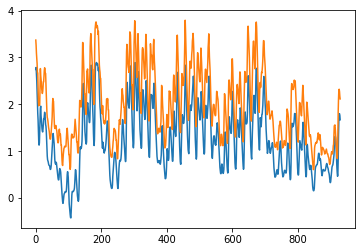

In [20]:
  ddf = pd.DataFrame(data={'Predictions': y_pred,
                          'Actuals':y_test
                          })
  plt.plot(ddf['Predictions'])
  plt.plot(ddf['Actuals'])

In [22]:
from sklearn.metrics import explained_variance_score,mean_squared_error, r2_score,max_error, mean_absolute_error, mean_absolute_percentage_error
def model_evaluate(model, y_test, y_pred):
  exp_var_score = explained_variance_score(y_test, y_pred)
  max_err= max_error(y_test, y_pred)
  r2= r2_score(y_test, y_pred)
  mae= mean_absolute_error(y_test, y_pred)
  mse= mean_squared_error(y_test, y_pred)
  rmse= np.sqrt(mse)
  mape = mean_absolute_percentage_error(y_test, y_pred)

  row_label = [model]
  
  data_score = { 'exp_varne': exp_var_score, 'max_error':max_err, 
                'r2': r2, 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape,}
  
  df_data = pd.DataFrame(data= data_score, index= row_label)
  
  return df_data

In [23]:
model_evaluate('LSTM',ddf['Actuals'], ddf['Predictions'])

,exp_varne,max_error,r2,mae,mse,rmse,mape
LSTM,0.900237,1.622864,-0.119364,0.757155,0.629377,0.793333,0.41985


In [24]:
y_true, y_pred = np.array(ddf['Actuals']), np.array(ddf['Predictions'])
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(mape)

41.98503401963309


In [25]:
c = df.columns
df[[c[0], c[6]]] = df[[c[6], c[0]]]

col_list = list(df)
# use this handy way to swap the elements
col_list[0], col_list[6] = col_list[6], col_list[0]
# assign back, the order will now be swapped
df.columns = col_list
df.head()

,NO2(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),CO(GT),PT08.S3(NOx),NOx(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day
date,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,0.347459,1.630928,0.311801,0.585979,0.317504,0.368408,0.126564,0.832721,0.492804,-0.566479,-0.010299,-0.657990,0.939133,0.0,-0.962879,-0.667207
2004-03-10 19:00:00,0.301885,1.398175,0.272546,0.311140,0.274973,0.404872,0.095617,0.582103,0.409136,-0.586400,-0.055889,-0.702414,1.083583,0.0,-0.962879,-0.667207
2004-03-10 20:00:00,0.321339,1.593386,0.255053,0.185523,0.271180,0.409315,0.095341,0.493948,0.402354,-0.660142,0.101989,-0.692531,1.228033,0.0,-0.962879,-0.667207
2004-03-10 21:00:00,0.341092,1.637413,0.248276,0.139569,0.269311,0.402815,0.107003,0.482535,0.420373,-0.731474,0.313287,-0.658257,1.372483,0.0,-0.962879,-0.667207
2004-03-10 22:00:00,0.346131,1.483408,0.222864,-0.058413,0.246718,0.416639,0.103684,0.386305,0.417687,-0.766721,0.429894,-0.636636,1.516933,0.0,-0.962879,-0.667207


In [26]:
df_1 = df.to_numpy()

X,Y=createXY(df_1,48)

X_train, y_train, X_valid, y_valid, X_test, y_test = split_train_test_LSTM(X, Y, 0.2, 0.1)

In [27]:
from keras.wrappers.scikit_learn import KerasRegressor

def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(64,return_sequences=True,input_shape=(48,16)))
    grid_model.add(LSTM(128))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(X_valid,y_valid))
parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

grid_search = grid_search.fit(X_train,y_train)

Epoch 1/8
204/204 [==============================] - 13s 49ms/step - loss: 0.0109 - val_loss: 0.0114
Epoch 2/8
204/204 [==============================] - 9s 46ms/step - loss: 0.0041 - val_loss: 0.0060
Epoch 3/8
204/204 [==============================] - 9s 45ms/step - loss: 0.0029 - val_loss: 0.0056
Epoch 4/8
204/204 [==============================] - 9s 46ms/step - loss: 0.0024 - val_loss: 0.0100
Epoch 5/8
204/204 [==============================] - 9s 46ms/step - loss: 0.0022 - val_loss: 0.0085
Epoch 6/8
204/204 [==============================] - 9s 46ms/step - loss: 0.0019 - val_loss: 0.0074
Epoch 7/8
204/204 [==============================] - 9s 46ms/step - loss: 0.0018 - val_loss: 0.0106
Epoch 8/8
204/204 [==============================] - 3s 13ms/step - loss: 0.0022
Epoch 1/8
204/204 [==============================] - 12s 48ms/step - loss: 0.0057 - val_loss: 0.0845
Epoch 2/8
204/204 [==============================] - 9s 45ms/step - loss: 0.0023 - val_loss: 0.0734
Epoch 3/8
204/204

In [28]:
grid_search.best_params_ 

{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}

In [29]:
my_model=grid_search.best_estimator_.model

In [30]:
prediction=my_model.predict(X_test)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)
prediction_copies = np.repeat(prediction, 7, axis=-1)
print(prediction_copies)
y_pred = scaler_1.inverse_transform(prediction_copies)[:,0]
print(y_pred)
y_test = np.reshape(y_test, (-1, 1))
y_test_copies = np.repeat(y_test, 7, axis=-1)
#print(y_test)
print(y_test_copies.shape)
y_test = scaler_1.inverse_transform(y_test_copies)[:,0]
y_test

30/30 [==============================] - 2s 22ms/step
prediction
 [[0.73039186]
 [0.73751354]
 [0.72606075]
 [0.7039913 ]
 [0.65518415]
 [0.6457511 ]
 [0.61910045]
 [0.60818505]
 [0.5627929 ]
 [0.51762843]
 [0.49825534]
 [0.5011517 ]
 [0.51902235]
 [0.53598905]
 [0.54909194]
 [0.54970074]
 [0.5344101 ]
 [0.53016484]
 [0.51957965]
 [0.5074612 ]
 [0.5031211 ]
 [0.5027219 ]
 [0.5154413 ]
 [0.5321637 ]
 [0.54897594]
 [0.5466585 ]
 [0.55257523]
 [0.55124295]
 [0.5264262 ]
 [0.513522  ]
 [0.49575537]
 [0.48810464]
 [0.469363  ]
 [0.44493595]
 [0.41808417]
 [0.39530382]
 [0.38737768]
 [0.38975647]
 [0.39003485]
 [0.38619646]
 [0.3834685 ]
 [0.38324437]
 [0.38269284]
 [0.3748234 ]
 [0.3645193 ]
 [0.36415663]
 [0.3698411 ]
 [0.38038543]
 [0.4019652 ]
 [0.41742337]
 [0.4332473 ]
 [0.44966766]
 [0.4563199 ]
 [0.4694799 ]
 [0.466306  ]
 [0.4620715 ]
 [0.44841605]
 [0.41688725]
 [0.38744876]
 [0.37591383]
 [0.37269035]
 [0.37274593]
 [0.3812467 ]
 [0.38165972]
 [0.37434542]
 [0.37353647]
 [0.367474

array([6.76898724, 6.69709142, 6.46540521, 6.31984478, 6.1340731 ,
       5.82170634, 5.82170634, 5.18056693, 4.68675013, 4.5376872 ,
       4.57058928, 4.57058928, 4.57058928, 4.70957485, 4.65516142,
       4.53441736, 4.52447048, 4.34535044, 4.22021813, 4.17442719,
       4.14812798, 4.25819298, 4.41052719, 4.56654333, 4.61374531,
       4.69832443, 4.67802572, 4.61613389, 4.48488953, 4.33072121,
       4.33072121, 4.10217068, 3.88229394, 3.64104642, 3.47290339,
       3.42026419, 3.42393053, 3.38070321, 3.3042929 , 3.22588345,
       3.18092402, 3.14853595, 3.07175423, 2.95806644, 2.95709006,
       3.00069033, 3.11598456, 3.28630732, 3.44870603, 3.62412096,
       3.75659794, 3.9803379 , 4.14372809, 4.09034329, 4.09034329,
       3.89198123, 3.55808756, 3.23580192, 3.1601768 , 3.1298679 ,
       3.13602268, 3.24343745, 3.25095977, 3.21685118, 3.24368016,
       3.18615038, 2.97412006, 2.88630086, 2.86725831, 2.95486618,
       3.14140517, 3.42544458, 3.53601693, 3.38373174, 3.32448

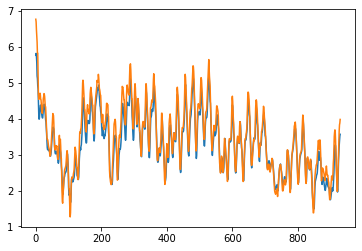

In [31]:
  ddf = pd.DataFrame(data={'Predictions': y_pred,
                          'Actuals':y_test
                          })
  plt.plot(ddf['Predictions'])
  plt.plot(ddf['Actuals'])

In [32]:
model_evaluate('LSTM',ddf['Actuals'], ddf['Predictions'])

,exp_varne,max_error,r2,mae,mse,rmse,mape
LSTM,0.950209,1.004876,0.915412,0.211628,0.071044,0.266542,0.059812


In [33]:
y_true, y_pred = np.array(ddf['Actuals']), np.array(ddf['Predictions'])
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(mape)

5.981172780541428
